# Attraction Basin Analysis: 500 Steps Visualization (Scaled)

This notebook analyzes data from `init_noise_diffusion_memorization/results/total_analysis_500`.

**Note:** The user states the data corresponds to a 500-step process, but the files may contain 50 steps (subsampled or compressed). This notebook automatically detects the data length and **scales the X-axis** to the target 500-step range to ensure the visualization matches the expected 0-500 domain.

1.  **Memorization Group (Aligned)**:
    *   **Logic**: $t_{exit}$ Alignment.
    *   **X-Axis**: Scaled Relative Steps.
    *   **Calculations**: Automatically filters Jacobian Norm values >= 10000 from Mean/Std calculations to remove extreme outliers.

2.  **Memorization Group (Absolute)**:
    *   **Logic**: Absolute Time 0-500 (No Alignment).

3.  **Memorization Group (Normalized Norm Diff)**:
    *   **Logic**: $t_{exit}$ Alignment, but Norm Diff scaled per sample s.t. Start=Mean(Starts), Exit=Mean(Exits).

4.  **Non-memorization Group**:
    *   **Logic**: Scaled Absolute Time 0-500.

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# --- Configuration ---
RESULTS_DIR = "results/total_analysis_500"
SAMPLES_TO_PROCESS = range(100) # Updated range to 100
TARGET_STEPS = 500

if not os.path.exists(RESULTS_DIR):
    print(f"Warning: Directory {RESULTS_DIR} does not exist. Check your path.")

In [34]:
# --- 1. Load Data ---
data_records = []
actual_steps_found = 0

print(f"Loading data from {RESULTS_DIR}...")

for idx in tqdm(SAMPLES_TO_PROCESS, desc="Loading CSVs"):
    sample_dir = os.path.join(RESULTS_DIR, f"sample_{idx:03d}")
    csv_path = os.path.join(sample_dir, "metrics.csv")
    
    if not os.path.exists(csv_path):
        continue
        
    try:
        df = pd.read_csv(csv_path)
        if actual_steps_found == 0:
            actual_steps_found = len(df)
        
        rec = {}
        for p_type in ["Memorization", "Non-memorization"]:
            rec[p_type] = {
                "Basin": df[f"{p_type}_Basin"].tolist(),
                "J_TE": df[f"{p_type}_J_TE"].tolist(),
                "AttnStab": df[f"{p_type}_AttnStab"].tolist()
            }
        
        data_records.append(rec)
    except Exception as e:
        print(f"Error reading Sample {idx}: {e}")

print(f"Loaded {len(data_records)} samples. Data Step Length: {actual_steps_found}")

SCALE_FACTOR = TARGET_STEPS / actual_steps_found if actual_steps_found > 0 else 1.0
print(f"Scaling X-axis by factor: {SCALE_FACTOR:.2f} (Base Steps: {actual_steps_found} -> Target: {TARGET_STEPS})")

Loading data from results/total_analysis_500...


Loading CSVs:   0%|          | 0/100 [00:00<?, ?it/s]

Loaded 100 samples. Data Step Length: 500
Scaling X-axis by factor: 1.00 (Base Steps: 500 -> Target: 500)


In [35]:
# --- 2. Process Memorization Group (Alignment & Scaling) ---

mem_aligned_data = []
mem_exit_stats = []
mem_dip_aligned_data = []
mem_dip_exit_stats = []

for record in data_records:
    p_type = "Memorization"
    basin = np.array(record[p_type]["Basin"])
    jacob = np.array(record[p_type]["J_TE"])
    attn = np.array(record[p_type]["AttnStab"])
    
    step_count = len(basin)
    t_exit_idx = np.argmax(basin)
    t_exit_scaled = t_exit_idx * SCALE_FACTOR
    
    # Filter Late Exit (> 400 in SCALED space)
    if t_exit_scaled > 400:
        continue
        
    len_pre = t_exit_idx
    len_post = step_count - 1 - t_exit_idx
    mem_exit_stats.append((len_pre, len_post))
    

    # --- New Logic: Find Basin Exit as Dip (Decrease then Increase) ---
    t_peak = np.argmax(basin)
    t_exit_dip = t_peak
    if t_peak < len(basin) - 5:
        post_peak = basin[t_peak:]
        w = 5
        if len(post_peak) >= w:
            kernel = np.ones(w)/w
            smoothed = np.convolve(post_peak, kernel, mode='valid')
            dip_idx_rel = np.argmin(smoothed) + w//2
            t_exit_dip = t_peak + dip_idx_rel
        else:
            t_exit_dip = t_peak + np.argmin(post_peak)
            
    # Refine t_exit_dip
    s_start = max(0, t_exit_dip - 3)
    s_end = min(len(basin), t_exit_dip + 4)
    if s_end > s_start:
        t_exit_dip = s_start + np.argmin(basin[s_start:s_end])

    # USER REQUEST: Shift regular dip by +20 steps
    t_exit_dip = min(t_exit_dip + 20, step_count - 1)
    len_pre_dip = t_exit_dip
    len_post_dip = len(basin) - 1 - t_exit_dip
    mem_dip_exit_stats.append((len_pre_dip, len_post_dip))
    mem_dip_aligned_data.append({
        't_exit': t_exit_dip,
        'basin': basin,
        'jacob': jacob,
        'attn': attn,
        'total_steps': step_count
    })

    mem_aligned_data.append({
        "t_exit": t_exit_idx,
        "basin": basin,
        "jacob": jacob,
        "attn": attn,
        "total_steps": step_count
    })

# Calculate Global Means for Normalization
all_starts = []
all_exits = []
for item in mem_aligned_data:
    t_e = item['t_exit']
    all_starts.append(item['basin'][0])
    all_exits.append(item['basin'][t_e])

global_mean_start = np.mean(all_starts) if all_starts else 1.0
global_mean_exit = np.mean(all_exits) if all_exits else 0.0
print(f"Global Mean Start: {global_mean_start:.4f}, Global Mean Exit: {global_mean_exit:.4f}")

def calculate_mem_stats(group_data, stats, normalization_target=None):
    if not group_data: return None, {}, None
    
    lens = np.array(stats)
    avg_pre_idx = int(np.mean(lens[:, 0]))
    avg_post_idx = int(np.mean(lens[:, 1]))
    
    # Indices Range
    x_indices = np.arange(-avg_pre_idx, avg_post_idx + 1)
    
    buckets = {k: {x: [] for x in x_indices} for k in ['basin', 'jacob', 'attn']}
    
    for item in group_data:
        t_e = item['t_exit']
        steps = item['total_steps']
        
        b_seq = item['basin']
        j_seq = item['jacob']
        a_seq = item['attn']
        
        # Normalization Logic
        if normalization_target:
            target_s, target_e = normalization_target
            val_s = b_seq[0]
            val_e = b_seq[t_e]
            
            denom = val_s - val_e
            if abs(denom) < 1e-9:
                alpha = 0.0
                beta = target_e
            else:
                alpha = (target_s - target_e) / denom
                beta = target_e - alpha * val_e
            
            b_seq = b_seq * alpha + beta
        
        for t_abs in range(steps):
            rel_t = t_abs - t_e
            
            if rel_t in x_indices:
                buckets['basin'][rel_t].append(b_seq[t_abs])
                
                # FILTER Jacobian Outliers >= 10000 from stats
                # This prevents extreme values from skewing the mean/std lines
                j_val = j_seq[t_abs]
                if j_val < 10000:
                    buckets['jacob'][rel_t].append(j_val)
                
                buckets['attn'][rel_t].append(a_seq[t_abs])
                
    res = {k: {'mean': [], 'std': []} for k in ['basin', 'jacob', 'attn']}
    
    for x in x_indices:
        for k in ['basin', 'jacob', 'attn']:
            vals = buckets[k][x]
            if vals:
                res[k]['mean'].append(np.mean(vals))
                res[k]['std'].append(np.std(vals))
            else:
                res[k]['mean'].append(np.nan)
                res[k]['std'].append(np.nan)
                
    # Scale X-Axis for Final Output
    scaled_x_axis = x_indices * SCALE_FACTOR
    return scaled_x_axis, res

mem_x_scaled, mem_stats = calculate_mem_stats(mem_aligned_data, mem_exit_stats, normalization_target=None)
mem_x_scaled_norm, mem_stats_norm = calculate_mem_stats(mem_aligned_data, mem_exit_stats, normalization_target=(global_mean_start, global_mean_exit))

mem_dip_x_scaled, mem_dip_stats = calculate_mem_stats(mem_dip_aligned_data, mem_dip_exit_stats, normalization_target=None)


Global Mean Start: 4.7999, Global Mean Exit: 9.0780


In [36]:
# --- 3. Process Memorization Group (Absolute Time 0-500) ---
mem_abs_data = {'basin': [], 'jacob': [], 'attn': []}
max_data_len = actual_steps_found if actual_steps_found > 0 else 500

for record in data_records:
    p_type = "Memorization"
    b = record[p_type]["Basin"]
    j = record[p_type]["J_TE"]
    a = record[p_type]["AttnStab"]
    
    if len(b) < max_data_len: b += [np.nan] * (max_data_len - len(b))
    if len(j) < max_data_len: j += [np.nan] * (max_data_len - len(j))
    if len(a) < max_data_len: a += [np.nan] * (max_data_len - len(a))
    
    b = b[:max_data_len]
    j = j[:max_data_len]
    a = a[:max_data_len]

    mem_abs_data['basin'].append(b)
    mem_abs_data['jacob'].append(j)
    mem_abs_data['attn'].append(a)

mem_abs_stats = {}
for k in ['basin', 'jacob', 'attn']:
    arr = np.array(mem_abs_data[k])
    mem_abs_stats[k] = {
        'mean': np.nanmean(arr, axis=0),
        'std': np.nanstd(arr, axis=0)
    }

if max_data_len > 0:
    mem_abs_x_scaled = np.arange(max_data_len) * SCALE_FACTOR
else:
    mem_abs_x_scaled = []

In [37]:
# --- 4. Process Non-memorization Group (Absolute Time 0-500) ---

non_mem_data = {'basin': [], 'jacob': [], 'attn': []}
# reusing max_data_len from previous cell

for record in data_records:
    p_type = "Non-memorization"
    b = record[p_type]["Basin"]
    j = record[p_type]["J_TE"]
    a = record[p_type]["AttnStab"]
    
    if len(b) < max_data_len: b += [np.nan] * (max_data_len - len(b))
    if len(j) < max_data_len: j += [np.nan] * (max_data_len - len(j))
    if len(a) < max_data_len: a += [np.nan] * (max_data_len - len(a))
    b = b[:max_data_len]
    j = j[:max_data_len]
    a = a[:max_data_len]
        
    non_mem_data['basin'].append(b)
    non_mem_data['jacob'].append(j)
    non_mem_data['attn'].append(a)

non_mem_stats = {}
for k in ['basin', 'jacob', 'attn']:
    arr = np.array(non_mem_data[k])
    non_mem_stats[k] = {
        'mean': np.nanmean(arr, axis=0),
        'std': np.nanstd(arr, axis=0)
    }

if max_data_len > 0:
    non_mem_x_scaled = np.arange(max_data_len) * SCALE_FACTOR
else:
    non_mem_x_scaled = []

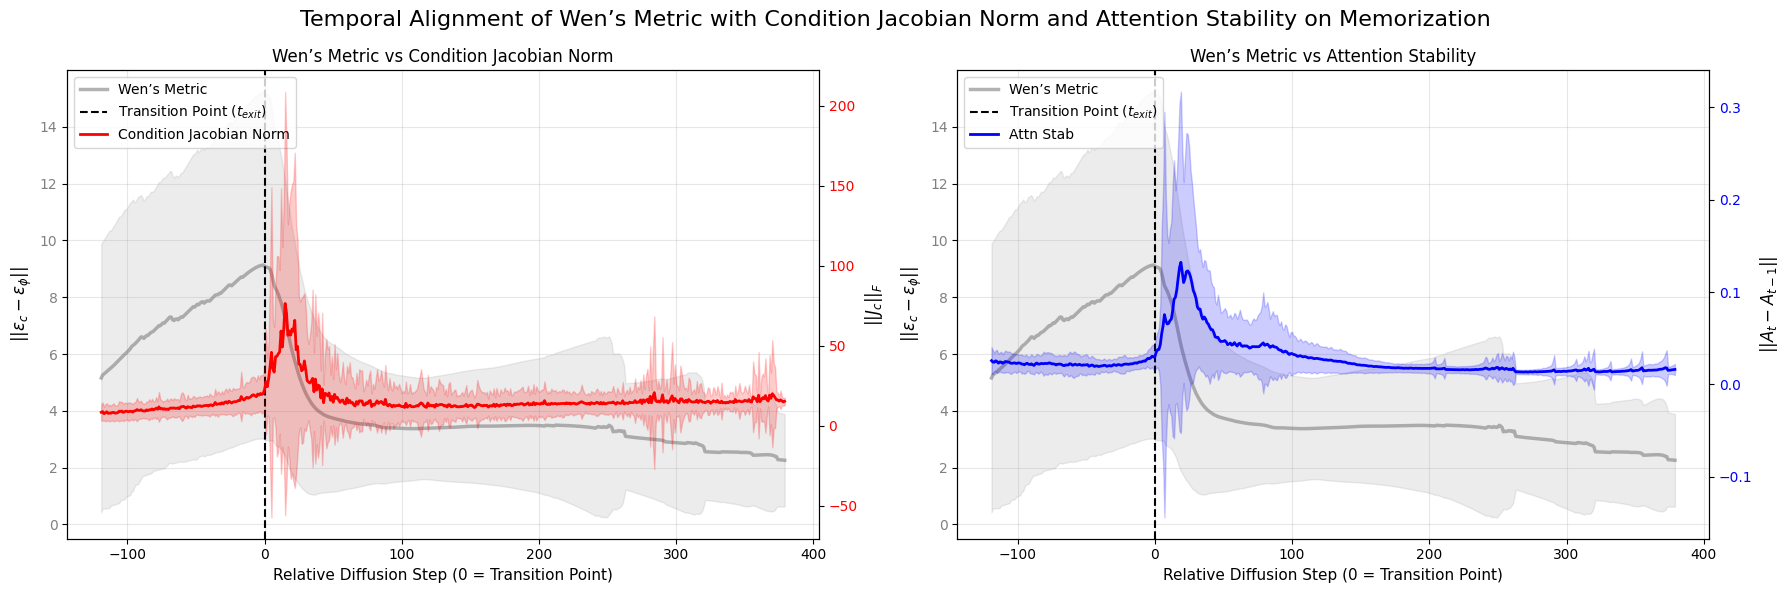

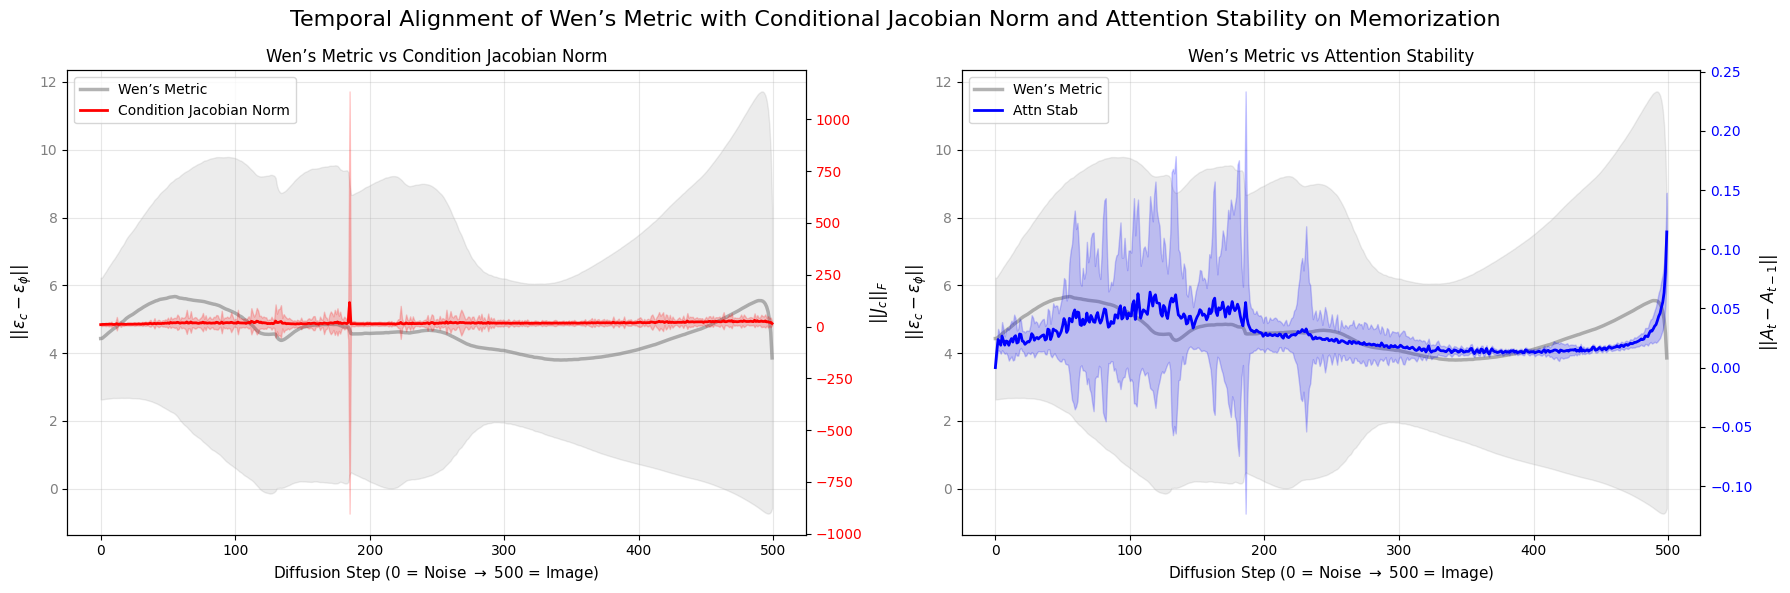

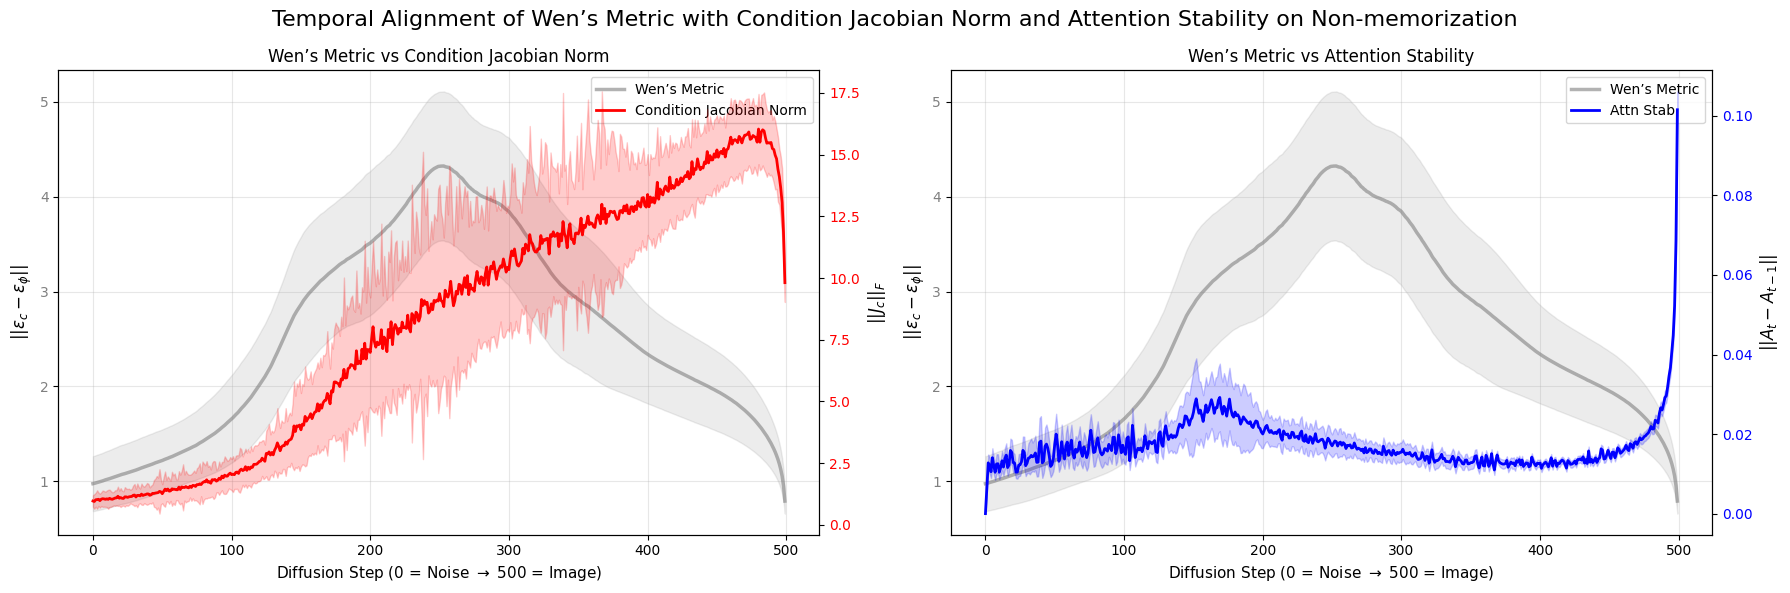

In [50]:
# --- 5. Visualization ---

def plot_with_std(ax, x, mean, std, color, label, ylabel, is_reference=False):
    mean = np.array(mean)
    std = np.array(std)
    
    if is_reference:
        ax.plot(x, mean, label=label, color=color, linewidth=2.5, alpha=0.6)
        ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.15)
    else:
        ax.plot(x, mean, label=label, color=color, linewidth=2)
        ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)
        
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='y', labelcolor=color)

# Labels
L_NORM = r'$||\epsilon_{c} - \epsilon_{\phi}||$'
L_JAC = r'$||J_c||_F$'
L_ATTN = r'$||A_t - A_{t-1}||$'

# === Figure 1: Memorization (Aligned - Raw) ===
if mem_x_scaled is not None:
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig1.suptitle(f"Temporal Alignment of Wen’s Metric with Condition Jacobian Norm and Attention Stability on Memorization", fontsize=16)
    
    # Subplot 1: Norm Diff vs Jacobian
    plot_with_std(ax1, mem_x_scaled, mem_stats['basin']['mean'], mem_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax1.set_xlabel("Relative Diffusion Step (0 = Transition Point)", fontsize=11)
    ax1.axvline(x=0, color='black', linestyle='--', label='Transition Point ($t_{exit}$)')
    
    ax1_r = ax1.twinx()
    plot_with_std(ax1_r, mem_x_scaled, mem_stats['jacob']['mean'], mem_stats['jacob']['std'], 'red', 'Condition Jacobian Norm', L_JAC)
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax1_r.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    ax1.set_title("Wen’s Metric vs Condition Jacobian Norm")
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Norm Diff vs Attention Stability
    plot_with_std(ax2, mem_x_scaled, mem_stats['basin']['mean'], mem_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax2.set_xlabel("Relative Diffusion Step (0 = Transition Point)", fontsize=11)
    ax2.axvline(x=0, color='black', linestyle='--', label='Transition Point ($t_{exit}$)')

    ax2_r = ax2.twinx()
    plot_with_std(ax2_r, mem_x_scaled, mem_stats['attn']['mean'], mem_stats['attn']['std'], 'blue', 'Attn Stab', L_ATTN)
    
    lines_3, labels_3 = ax2.get_legend_handles_labels()
    lines_4, labels_4 = ax2_r.get_legend_handles_labels()
    ax2.legend(lines_3 + lines_4, labels_3 + labels_4, loc='upper left')
    ax2.set_title("Wen’s Metric vs Attention Stability")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# === Figure 3: Memorization (Absolute) ===
if len(mem_abs_x_scaled) > 0:
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 6))
    fig2.suptitle(f"Temporal Alignment of Wen’s Metric with Conditional Jacobian Norm and Attention Stability on Memorization", fontsize=16)
    
    # Subplot 3: Wen’s Metric vs Jacobian
    plot_with_std(ax3, mem_abs_x_scaled, mem_abs_stats['basin']['mean'], mem_abs_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax3.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax3_r = ax3.twinx()
    plot_with_std(ax3_r, mem_abs_x_scaled, mem_abs_stats['jacob']['mean'], mem_abs_stats['jacob']['std'], 'red', 'Condition Jacobian Norm', L_JAC)
    
    l3, lb3 = ax3.get_legend_handles_labels()
    l4, lb4 = ax3_r.get_legend_handles_labels()
    ax3.legend(l3 + l4, lb3 + lb4, loc='best')
    ax3.set_title("Wen’s Metric vs Condition Jacobian Norm")
    ax3.grid(True, alpha=0.3)

    # Subplot 4: Wen’s Metric vs Attention Stability
    plot_with_std(ax4, mem_abs_x_scaled, mem_abs_stats['basin']['mean'], mem_abs_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax4.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax4_r = ax4.twinx()
    plot_with_std(ax4_r, mem_abs_x_scaled, mem_abs_stats['attn']['mean'], mem_abs_stats['attn']['std'], 'blue', 'Attn Stab', L_ATTN)
    
    l5, lb5 = ax4.get_legend_handles_labels()
    l6, lb6 = ax4_r.get_legend_handles_labels()
    ax4.legend(l5 + l6, lb5 + lb6, loc='best')
    ax4.set_title("Wen’s Metric vs Attention Stability")
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# === Figure 4: Non-memorization ===
if len(non_mem_x_scaled) > 0:
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(18, 6))
    fig3.suptitle(f"Temporal Alignment of Wen’s Metric with Condition Jacobian Norm and Attention Stability on Non-memorization", fontsize=16)
    
    # Subplot 5: Wen’s Metric vs Jacobian
    plot_with_std(ax5, non_mem_x_scaled, non_mem_stats['basin']['mean'], non_mem_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax5.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax5_r = ax5.twinx()
    plot_with_std(ax5_r, non_mem_x_scaled, non_mem_stats['jacob']['mean'], non_mem_stats['jacob']['std'], 'red','Condition Jacobian Norm', L_JAC)
    
    l5, lb5 = ax5.get_legend_handles_labels()
    l6, lb6 = ax5_r.get_legend_handles_labels()
    ax5.legend(l5 + l6, lb5 + lb6, loc='best')
    ax5.set_title("Wen’s Metric vs Condition Jacobian Norm")
    ax5.grid(True, alpha=0.3)

    # Subplot 6: Wen’s Metric vs Attention Stability
    plot_with_std(ax6, non_mem_x_scaled, non_mem_stats['basin']['mean'], non_mem_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax6.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax6_r = ax6.twinx()
    plot_with_std(ax6_r, non_mem_x_scaled, non_mem_stats['attn']['mean'], non_mem_stats['attn']['std'], 'blue', 'Attn Stab', L_ATTN)
    
    l7, lb7 = ax6.get_legend_handles_labels()
    l8, lb8 = ax6_r.get_legend_handles_labels()
    ax6.legend(l7 + l8, lb7 + lb8, loc='best')
    ax6.set_title("Wen’s Metric vs Attention Stability")
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Total filtered outliers (Jacobian Norm >= 10000): 1
Top 5 Steps with Highest Jacobian Variance (Filtered < 10000): [21.  5. 22. 16. 15.]


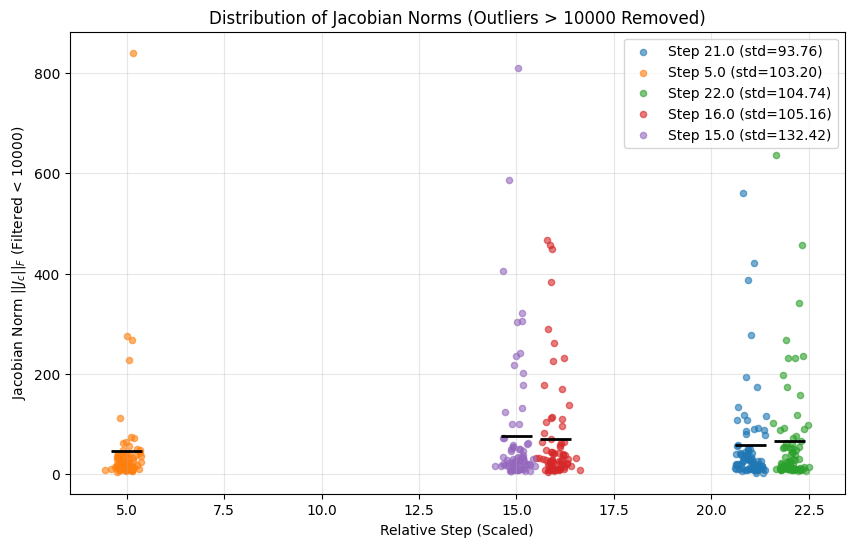


--- Norm Diff Variance Analysis ---
Top 10 Steps with Highest Norm Diff Variance: [-6. -5.  3. -4.  2. -3. -2.  1.  0. -1.]


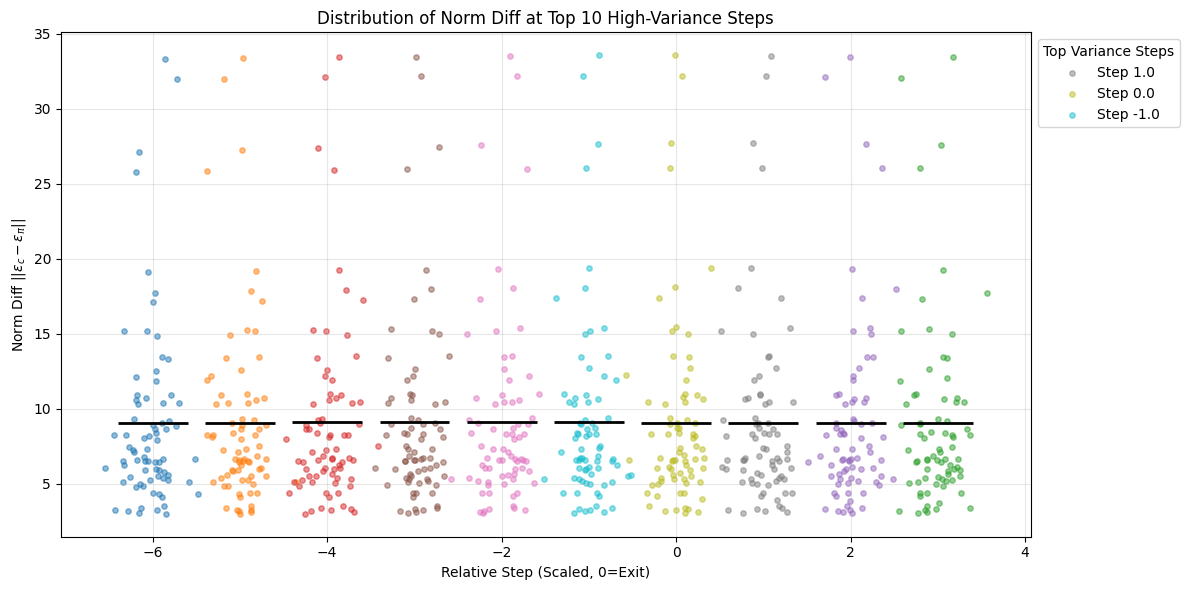

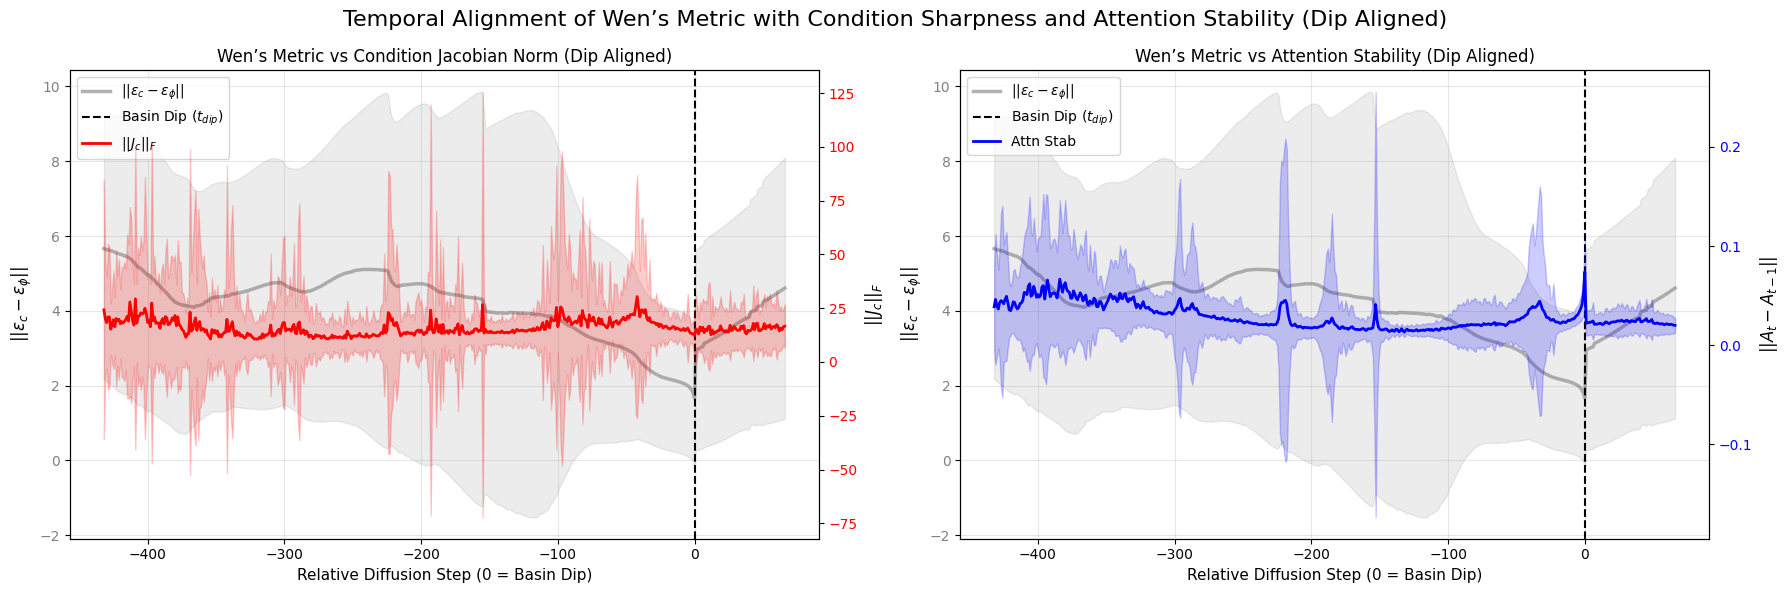

In [41]:
# --- 6. Jacobian Outlier Analysis (Scatter Plot: Filtered < 10000) ---

if mem_x_scaled is not None:
    # 1. Collect Valid Data (Filter outliers >= 10000) & Identify Top 5 High-Variance Steps
    x_axis = mem_x_scaled
    outlier_total_count = 0
    
    # Temporary structure to hold cleaned data for variance calculation
    # clean_buckets = { step_index: [val1, val2, ...] }
    clean_buckets = {i: [] for i in range(len(x_axis))}
    
    # Re-iterate to fill buckets with filtered data
    for record in mem_aligned_data:
        t_e = record['t_exit']
        j_seq = record['jacob']
        
        min_scaled_t = x_axis[0]
        min_rel_t = int(round(min_scaled_t / SCALE_FACTOR))
        
        for t_abs in range(len(j_seq)):
            rel_t = t_abs - t_e
            # Find index in x_axis array
            arr_idx = rel_t - min_rel_t
            
            if 0 <= arr_idx < len(x_axis):
                val = j_seq[t_abs]
                if val < 10000:  # <--- FILTER CRITERIA
                    clean_buckets[arr_idx].append(val)
                else:
                    outlier_total_count += 1

    print(f"Total filtered outliers (Jacobian Norm >= 10000): {outlier_total_count}")

    # Calculate std only on cleaned data
    clean_stds = []
    for i in range(len(x_axis)):
        vals = clean_buckets[i]
        if len(vals) > 5: # minimal samples to count as valid step
            clean_stds.append(np.std(vals))
        else:
            clean_stds.append(-1.0) # Mask invalid
            
    clean_stds = np.array(clean_stds)
    
    # Find top 5 variance indices
    top5_indices = np.argsort(clean_stds)[-5:]
    top5_steps_scaled = x_axis[top5_indices]
    top5_stds = clean_stds[top5_indices]

    print(f"Top 5 Steps with Highest Jacobian Variance (Filtered < 10000): {top5_steps_scaled}")

    # 2. Plotting Jacobian Scatter
    plt.figure(figsize=(10, 6))
    jitter_width = SCALE_FACTOR * 0.2

    for i, step_scaled in enumerate(top5_steps_scaled):
        arr_idx = top5_indices[i]
        vals = clean_buckets[arr_idx]
        
        if vals:
            x_jit = np.random.normal(step_scaled, jitter_width, size=len(vals))
            plt.scatter(x_jit, vals, alpha=0.6, s=20, label=f"Step {step_scaled:.1f} (std={top5_stds[i]:.2f})")
            plt.hlines(np.mean(vals), step_scaled - jitter_width*2, step_scaled + jitter_width*2, colors='black', linewidth=2)

    plt.xlabel("Relative Step (Scaled)")
    plt.ylabel(r"Jacobian Norm $||J_c||_F$ (Filtered < 10000)")
    plt.title("Distribution of Jacobian Norms (Outliers > 10000 Removed)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # --- 7. Norm Diff Scatter Analysis (Top 10 High-Variance Steps) ---
    print("\n--- Norm Diff Variance Analysis ---")
    norm_buckets = {i: [] for i in range(len(x_axis))}
    
    # Re-iterate to fill buckets with norm diff data
    for record in mem_aligned_data:
        t_e = record['t_exit']
        b_seq = record['basin']
        
        min_scaled_t = x_axis[0]
        min_rel_t = int(round(min_scaled_t / SCALE_FACTOR))
        
        for t_abs in range(len(b_seq)):
            rel_t = t_abs - t_e
            arr_idx = rel_t - min_rel_t
            
            if 0 <= arr_idx < len(x_axis):
                norm_buckets[arr_idx].append(b_seq[t_abs])

    # Calculate std
    norm_stds = []
    for i in range(len(x_axis)):
        vals = norm_buckets[i]
        if len(vals) > 5:
            norm_stds.append(np.std(vals))
        else:
            norm_stds.append(-1.0)
            
    norm_stds = np.array(norm_stds)
    
    # Find top 10 variance indices for Norm Diff
    top10_norm_indices = np.argsort(norm_stds)[-10:]
    top10_norm_steps_scaled = x_axis[top10_norm_indices]
    top10_norm_stds = norm_stds[top10_norm_indices]
    
    print(f"Top 10 Steps with Highest Norm Diff Variance: {top10_norm_steps_scaled}")
    
    # Plotting Norm Diff Scatter
    plt.figure(figsize=(12, 6))

    for i, step_scaled in enumerate(top10_norm_steps_scaled):
        arr_idx = top10_norm_indices[i]
        vals = norm_buckets[arr_idx]
        
        if vals:
            x_jit = np.random.normal(step_scaled, jitter_width, size=len(vals))
            # Only label top 3 to keep legend clean, or customized label
            lbl = f"Step {step_scaled:.1f}" if i >= 7 else "" 
            plt.scatter(x_jit, vals, alpha=0.5, s=15, label=lbl)
            plt.hlines(np.mean(vals), step_scaled - jitter_width*2, step_scaled + jitter_width*2, colors='k', linewidth=2)

    plt.xlabel("Relative Step (Scaled, 0=Exit)")
    plt.ylabel(r"Norm Diff $|| \epsilon_c - \epsilon_{\pi} ||$")
    plt.title("Distribution of Norm Diff at Top 10 High-Variance Steps")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Top Variance Steps")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Mem aligned data not available.")


# --- Plot Basin Dip Alignment ---
# === Figure 4: Memorization (Dip Aligned) ===
if 'mem_dip_x_scaled' in locals() and mem_dip_x_scaled is not None:
    fig4, (ax7, ax8) = plt.subplots(1, 2, figsize=(18, 6))
    fig4.suptitle(f"Temporal Alignment of Wen’s Metric with Condition Sharpness and Attention Stability (Dip Aligned)", fontsize=16)
    
    # Subplot 1: Norm Diff vs Jacobian
    plot_with_std(ax7, mem_dip_x_scaled, mem_dip_stats['basin']['mean'], mem_dip_stats['basin']['std'], 'gray', L_NORM, L_NORM, is_reference=True)
    ax7.set_xlabel("Relative Diffusion Step (0 = Basin Dip)", fontsize=11)
    ax7.axvline(x=0, color='black', linestyle='--', label='Basin Dip ($t_{dip}$)')
    
    ax7_r = ax7.twinx()
    plot_with_std(ax7_r, mem_dip_x_scaled, mem_dip_stats['jacob']['mean'], mem_dip_stats['jacob']['std'], 'red', L_JAC, L_JAC)
    
    lines_a, labels_a = ax7.get_legend_handles_labels()
    lines_b, labels_b = ax7_r.get_legend_handles_labels()
    ax7.legend(lines_a + lines_b, labels_a + labels_b, loc='upper left')
    ax7.set_title("Wen’s Metric vs Condition Jacobian Norm (Dip Aligned)")
    ax7.grid(True, alpha=0.3)

    # Subplot 2: Norm Diff vs Attention Stability
    plot_with_std(ax8, mem_dip_x_scaled, mem_dip_stats['basin']['mean'], mem_dip_stats['basin']['std'], 'gray', L_NORM, L_NORM, is_reference=True)
    ax8.set_xlabel("Relative Diffusion Step (0 = Basin Dip)", fontsize=11)
    ax8.axvline(x=0, color='black', linestyle='--', label='Basin Dip ($t_{dip}$)')

    ax8_r = ax8.twinx()
    plot_with_std(ax8_r, mem_dip_x_scaled, mem_dip_stats['attn']['mean'], mem_dip_stats['attn']['std'], 'blue', 'Attn Stab', L_ATTN)
    
    lines_c, labels_c = ax8.get_legend_handles_labels()
    lines_d, labels_d = ax8_r.get_legend_handles_labels()
    ax8.legend(lines_c + lines_d, labels_c + labels_d, loc='upper left')
    ax8.set_title("Wen’s Metric vs Attention Stability (Dip Aligned)")
    ax8.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [ ]:
# --- 5. Visualization ---

def plot_with_std(ax, x, mean, std, color, label, ylabel, is_reference=False):
    mean = np.array(mean)
    std = np.array(std)
    
    if is_reference:
        ax.plot(x, mean, label=label, color=color, linewidth=2.5, alpha=0.6)
        ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.15)
    else:
        ax.plot(x, mean, label=label, color=color, linewidth=2)
        ax.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)
        
    ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='y', labelcolor=color)

# Labels
L_NORM = r'$||\epsilon_{c} - \epsilon_{\phi}||$'
L_JAC = r'$||J_c||_F$'
L_ATTN = r'$||A_t - A_{t-1}||$'

# === Figure 1: Memorization (Aligned - Raw) ===
if mem_x_scaled is not None:
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    fig1.suptitle(f"Temporal Alignment of Wen’s Metric with Conditional Sharpness and Attention Stability on Memorization", fontsize=16)
    
    # Subplot 1: Norm Diff vs Jacobian
    plot_with_std(ax1, mem_x_scaled, mem_stats['basin']['mean'], mem_stats['basin']['std'], 'gray', L_NORM, L_NORM, is_reference=True)
    ax1.set_xlabel("Relative Diffusion Step (0 = Basin Exit)", fontsize=11)
    ax1.axvline(x=0, color='black', linestyle='--', label='Basin Exit ($t_{exit}$)')
    
    ax1_r = ax1.twinx()
    plot_with_std(ax1_r, mem_x_scaled, mem_stats['jacob']['mean'], mem_stats['jacob']['std'], 'red', L_JAC, L_JAC)
    
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax1_r.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    ax1.set_title("Wen’s Metric vs Conditional Jacobian Norm")
    ax1.grid(True, alpha=0.3)

    # Subplot 2: Norm Diff vs Attention Stability
    plot_with_std(ax2, mem_x_scaled, mem_stats['basin']['mean'], mem_stats['basin']['std'], 'gray', L_NORM, L_NORM, is_reference=True)
    ax2.set_xlabel("Relative Diffusion Step (0 = Basin Exit)", fontsize=11)
    ax2.axvline(x=0, color='black', linestyle='--', label='Basin Exit ($t_{exit}$)')

    ax2_r = ax2.twinx()
    plot_with_std(ax2_r, mem_x_scaled, mem_stats['attn']['mean'], mem_stats['attn']['std'], 'blue', 'Attn Stab', L_ATTN)
    
    lines_3, labels_3 = ax2.get_legend_handles_labels()
    lines_4, labels_4 = ax2_r.get_legend_handles_labels()
    ax2.legend(lines_3 + lines_4, labels_3 + labels_4, loc='upper left')
    ax2.set_title("Wen’s Metric vs Attention Stability")
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


# === Figure 3: Memorization (Absolute) ===
if len(mem_abs_x_scaled) > 0:
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(18, 6))
    fig2.suptitle(f"Temporal Alignment of Wen’s Metric with Conditional Sharpness and Attention Stability on Memorization", fontsize=16)
    
    # Subplot 3: Wen’s Metric vs Jacobian
    plot_with_std(ax3, mem_abs_x_scaled, mem_abs_stats['basin']['mean'], mem_abs_stats['basin']['std'], 'gray', L_NORM, L_NORM, is_reference=True)
    ax3.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax3_r = ax3.twinx()
    plot_with_std(ax3_r, mem_abs_x_scaled, mem_abs_stats['jacob']['mean'], mem_abs_stats['jacob']['std'], 'red', L_JAC, L_JAC)
    
    l3, lb3 = ax3.get_legend_handles_labels()
    l4, lb4 = ax3_r.get_legend_handles_labels()
    ax3.legend(l3 + l4, lb3 + lb4, loc='best')
    ax3.set_title("Wen’s Metric vs Jacobian Norm")
    ax3.grid(True, alpha=0.3)

    # Subplot 4: Wen’s Metric vs Attention Stability
    plot_with_std(ax4, mem_abs_x_scaled, mem_abs_stats['basin']['mean'], mem_abs_stats['basin']['std'], 'gray', L_NORM, L_NORM, is_reference=True)
    ax4.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax4_r = ax4.twinx()
    plot_with_std(ax4_r, mem_abs_x_scaled, mem_abs_stats['attn']['mean'], mem_abs_stats['attn']['std'], 'blue', 'Attn Stab', L_ATTN)
    
    l5, lb5 = ax4.get_legend_handles_labels()
    l6, lb6 = ax4_r.get_legend_handles_labels()
    ax4.legend(l5 + l6, lb5 + lb6, loc='best')
    ax4.set_title("Wen’s Metric vs Attention Stability")
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# === Figure 4: Non-memorization ===
if len(non_mem_x_scaled) > 0:
    fig3, (ax5, ax6) = plt.subplots(1, 2, figsize=(18, 6))
    fig3.suptitle(f"Temporal Alignment of Wen’s Metric with Condition Sharpness and Attention Stability on Non-memorization", fontsize=16)
    
    # Subplot 5: Wen’s Metric vs Jacobian
    plot_with_std(ax5, non_mem_x_scaled, non_mem_stats['basin']['mean'], non_mem_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax5.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax5_r = ax5.twinx()
    plot_with_std(ax5_r, non_mem_x_scaled, non_mem_stats['jacob']['mean'], non_mem_stats['jacob']['std'], 'red',L_JAC, L_JAC)
    
    l5, lb5 = ax5.get_legend_handles_labels()
    l6, lb6 = ax5_r.get_legend_handles_labels()
    ax5.legend(l5 + l6, lb5 + lb6, loc='best')
    ax5.set_title("Wen’s Metric vs Jacobian Norm")
    ax5.grid(True, alpha=0.3)

    # Subplot 6: Wen’s Metric vs Attention Stability
    plot_with_std(ax6, non_mem_x_scaled, non_mem_stats['basin']['mean'], non_mem_stats['basin']['std'], 'gray', 'Wen’s Metric', L_NORM, is_reference=True)
    ax6.set_xlabel(fr"Diffusion Step (0 = Noise $\rightarrow$ {TARGET_STEPS} = Image)", fontsize=11)
    
    ax6_r = ax6.twinx()
    plot_with_std(ax6_r, non_mem_x_scaled, non_mem_stats['attn']['mean'], non_mem_stats['attn']['std'], 'blue', 'Attn Stab', L_ATTN)
    
    l7, lb7 = ax6.get_legend_handles_labels()
    l8, lb8 = ax6_r.get_legend_handles_labels()
    ax6.legend(l7 + l8, lb7 + lb8, loc='best')
    ax6.set_title("Wen’s Metric vs Attention Stability")
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()